# Load modules and data

### import the necessary packages

In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col


spark = SparkSession.builder.appName('Preprocessing').getOrCreate()

22/11/03 10:15:44 WARN Utils: Your hostname, tars resolves to a loopback address: 127.0.1.1; using 192.168.1.66 instead (on interface wlan0)
22/11/03 10:15:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/03 10:15:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### load data into weather_df

In [2]:
weather_df = spark\
            .read\
            .option('inferSchema', 'true')\
            .option('header', 'true')\
            .csv('data/daily_weather_data.csv')

weather_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- tavg: double (nullable = true)
 |-- tmin: double (nullable = true)
 |-- tmax: double (nullable = true)
 |-- wdir: integer (nullable = true)
 |-- wspd: double (nullable = true)
 |-- pres: double (nullable = true)



In [3]:
weather_df.rdd.getNumPartitions()

7

In [4]:
# number of rows
weather_df.count()

324647

In [5]:
# example data
weather_df.show(3)

+----------+--------+-------+---------+---------+----+----+----+----+----+------+
|      date| country|   city| Latitude|Longitude|tavg|tmin|tmax|wdir|wspd|  pres|
+----------+--------+-------+---------+---------+----+----+----+----+----+------+
|21-07-2018|Abkhazia|Sukhumi|43.001525|41.023415|23.4|20.9|25.5| 329| 9.3|1009.6|
|22-07-2018|Abkhazia|Sukhumi|43.001525|41.023415|23.5|21.0|25.7| 337| 9.4|1010.0|
|23-07-2018|Abkhazia|Sukhumi|43.001525|41.023415|23.5|21.1|25.5|  41| 8.2|1007.7|
+----------+--------+-------+---------+---------+----+----+----+----+----+------+
only showing top 3 rows



# Data cleaning

## 1. Cleaning Weather Data

In [6]:
# count how many null values are in each column

weather_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in weather_df.columns]).show()

+----+-------+----+--------+---------+----+-----+-----+-----+-----+-----+
|date|country|city|Latitude|Longitude|tavg| tmin| tmax| wdir| wspd| pres|
+----+-------+----+--------+---------+----+-----+-----+-----+-----+-----+
|   0|      0|   0|       0|        0|9684|12363|12378|40710|22247|35231|
+----+-------+----+--------+---------+----+-----+-----+-----+-----+-----+



### lets see what kind of nulls we are dealing with

In [7]:
weather_df.where(col('tavg').isNull()).show()

# seems in most cases all important weather data columns are null
weather_df.where(col('tavg').isNull() & col('tmin').isNull() & col('tmax').isNull() & col('wdir').isNull() & col('wspd').isNull() & col('pres').isNull()).count()
# 7436

+----------+-------------+---------+---------+---------+----+----+----+----+----+----+
|      date|      country|     city| Latitude|Longitude|tavg|tmin|tmax|wdir|wspd|pres|
+----------+-------------+---------+---------+---------+----+----+----+----+----+----+
|03-06-2022|     Abkhazia|  Sukhumi|43.001525|41.023415|null|null|null|null|null|null|
|04-06-2022|     Abkhazia|  Sukhumi|43.001525|41.023415|null|null|null|null|null|null|
|05-06-2022|     Abkhazia|  Sukhumi|43.001525|41.023415|null|null|null|null|null|null|
|06-06-2022|     Abkhazia|  Sukhumi|43.001525|41.023415|null|null|null|null|null|null|
|07-06-2022|     Abkhazia|  Sukhumi|43.001525|41.023415|null|null|null|null|null|null|
|08-06-2022|     Abkhazia|  Sukhumi|43.001525|41.023415|null|null|null|null|null|null|
|09-06-2022|     Abkhazia|  Sukhumi|43.001525|41.023415|null|null|null|null|null|null|
|10-06-2022|     Abkhazia|  Sukhumi|43.001525|41.023415|null|null|null|null|null|null|
|11-06-2022|     Abkhazia|  Sukhumi|43.0015

7436

In [8]:
# rows having atleast one null value

weather_df.count() - weather_df.dropna(how='any').count() # 47096 
# that's too many rows

47096

In [9]:
# further, wdir is not important to us in our analysis
# so drop the column wdir

weather_clean1_df = weather_df.drop('wdir')
weather_clean1_df.count() - weather_clean1_df.dropna(how='any').count() # 36000 rows with atleast one null column

36095

### Remove duplicates

In [10]:
weather_clean1_df.dropDuplicates().count() - weather_df.count()

# we don't have any duplicates

0

### Dropping null columns of tavg, tmin, tmax and wspd
it is not possible to fill the tavg, tmin, tmax, wspd columns with mean values because the values belong to various different countries at different dates of year

In [11]:
# since tavg, tmin, tmax, wspd are crucial to our analysis, we drop all those rows where atleast one of them is null

weather_clean2_df = weather_clean1_df.dropna(how='any', subset=['tavg', 'tmin', 'tmax', 'wspd'])

weather_df.count() - weather_clean2_df.count() #24302 rows removed

24302

In [12]:
# lets see the new count of null records
weather_clean2_df.select([F.count(F.when(col(c).isNull(), c)).alias(c) for c in weather_clean2_df.columns]).show()

+----+-------+----+--------+---------+----+----+----+----+-----+
|date|country|city|Latitude|Longitude|tavg|tmin|tmax|wspd| pres|
+----+-------+----+--------+---------+----+----+----+----+-----+
|   0|      0|   0|       0|        0|   0|   0|   0|   0|11793|
+----+-------+----+--------+---------+----+----+----+----+-----+



In [13]:
# 11793 columns where pressure is null
# atmospheric pressure at a place is almost constant, lets fill this with mean data

weather_clean2_df.describe('pres').show()

+-------+------------------+
|summary|              pres|
+-------+------------------+
|  count|            288552|
|   mean|1013.2756026643319|
| stddev| 7.159268129686839|
|    min|             922.8|
|    max|            1058.0|
+-------+------------------+



In [14]:
# lets first check the skewness and kurtosis of pressure column

weather_clean2_df.select(F.skewness('pres'),F.kurtosis('pres')).show()

+--------------------+-----------------+
|      skewness(pres)|   kurtosis(pres)|
+--------------------+-----------------+
|-0.43519641065412124|4.418189473399529|
+--------------------+-----------------+



skewness of -0.43 i.e. < 0 means that data is negatively skewed.

kurtosis of 4.42 i.e. > 3 means that the data is leptokurtic i.e. there are many outliers. lets make a box plot to see the distribution of data

<AxesSubplot: >

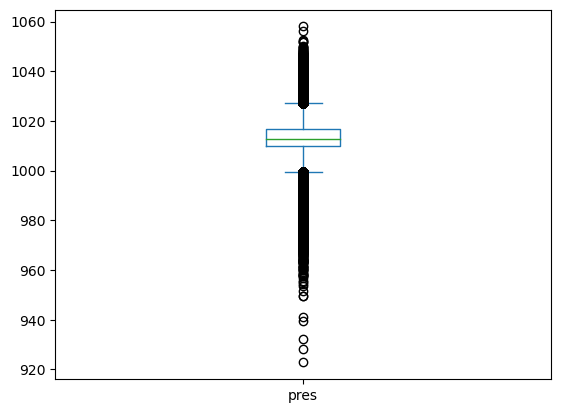

In [15]:
weather_clean2_df.toPandas().plot.box(column=['pres'])

even though the data is skewed to left of the mean, we can see that there are not many outliers, so we fill null rows with mean pressure

In [16]:
mean_pres = weather_clean2_df.select(F.mean(weather_clean2_df['pres'])).collect()[0][0]
mean_pres # 1013.27

# fill nulls in pressure column with mean pressure
weather_cleaned_df = weather_clean2_df.fillna(mean_pres, subset=['pres'])

In [17]:
# lets see the new count of null records
weather_cleaned_df.select([F.count(F.when(col(c).isNull(), c)).alias(c) for c in weather_clean2_df.columns]).show()

+----+-------+----+--------+---------+----+----+----+----+----+
|date|country|city|Latitude|Longitude|tavg|tmin|tmax|wspd|pres|
+----+-------+----+--------+---------+----+----+----+----+----+
|   0|      0|   0|       0|        0|   0|   0|   0|   0|   0|
+----+-------+----+--------+---------+----+----+----+----+----+



## Fixing the date column

In [18]:
weather_cleaned_df = weather_cleaned_df.withColumn('date', F.to_date(F.col('date'), 'dd-MM-yyyy'))

weather_cleaned_df.select('date').show()

+----------+
|      date|
+----------+
|2018-07-21|
|2018-07-22|
|2018-07-23|
|2018-07-24|
|2018-07-25|
|2018-07-26|
|2018-07-27|
|2018-07-28|
|2018-07-29|
|2018-07-30|
|2018-07-31|
|2018-08-01|
|2018-08-02|
|2018-08-03|
|2018-08-04|
|2018-08-05|
|2018-08-06|
|2018-08-07|
|2018-08-08|
|2018-08-09|
+----------+
only showing top 20 rows



In [28]:
weather_cleaned_df.printSchema()

root
 |-- date: date (nullable = true)
 |-- country: string (nullable = true)
 |-- city: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- tavg: double (nullable = true)
 |-- tmin: double (nullable = true)
 |-- tmax: double (nullable = true)
 |-- wspd: double (nullable = true)
 |-- pres: double (nullable = false)



### final row count

In [19]:
weather_cleaned_df.count()

300345

### export to csv

In [20]:
# weather_cleaned_df is our final df, which we'll export to another csv file

weather_cleaned_df.toPandas().to_csv('cleaned_data/cleaned_weather_data.csv', index=False)

## 2. Cleaning Continents data

In [21]:
continents_df = spark\
                .read\
                .option('inferSchema', 'true')\
                .option('header', 'true')\
                .csv('data/country_continent.csv')

continents_df.show(3)
continents_df.printSchema()
continents_df.count()

+-------------+------+------+------------+-------------+---------+---------------+-----------+---------------+
|      country|code_2|code_3|country_code|   iso_3166_2|continent|     sub_region|region_code|sub_region_code|
+-------------+------+------+------------+-------------+---------+---------------+-----------+---------------+
|  Afghanistan|    AF|   AFG|           4|ISO 3166-2:AF|     Asia|  Southern Asia|        142|             34|
|�land Islands|    AX|   ALA|         248|ISO 3166-2:AX|   Europe|Northern Europe|        150|            154|
|      Albania|    AL|   ALB|           8|ISO 3166-2:AL|   Europe|Southern Europe|        150|             39|
+-------------+------+------+------------+-------------+---------+---------------+-----------+---------------+
only showing top 3 rows

root
 |-- country: string (nullable = true)
 |-- code_2: string (nullable = true)
 |-- code_3: string (nullable = true)
 |-- country_code: integer (nullable = true)
 |-- iso_3166_2: string (nullable

249

we need only country and continent columns, so we drop all other columns

In [22]:
continents_clean1_df = continents_df.select('country', 'continent')

In [23]:
# check for null columns
continents_clean1_df.select([F.count(F.when(col(c).isNull(), c)).alias(c) for c in continents_clean1_df.columns]).show()
# 9 null columns in continent

+-------+---------+
|country|continent|
+-------+---------+
|      0|        9|
+-------+---------+



In [24]:
continents_clean1_df.where(col('continent').isNull()).show()

+--------------------+---------+
|             country|continent|
+--------------------+---------+
|          Antarctica|     null|
|       Bouvet Island|     null|
|British Indian Oc...|     null|
|    Christmas Island|     null|
|Cocos (Keeling) I...|     null|
|French Southern T...|     null|
|Heard Island and ...|     null|
|South Georgia and...|     null|
|United States Min...|     null|
+--------------------+---------+



In [25]:
# these countries are not included in our weather data list, so we can drop these

continents_cleaned_df = continents_clean1_df.dropna(how='any')
continents_df.count() - continents_cleaned_df.count() # 9

9

### final row count

In [26]:
continents_cleaned_df.count()

240

### export to csv

In [27]:
continents_cleaned_df.toPandas().to_csv('cleaned_data/cleaned_country_continent.csv', index=False)